## Environment setup

### Packages

In [19]:
import os, json, time, cv2, sys, shutil, gc

import torch, torchvision
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.transforms import functional as F
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline 

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.splits import create_splits_scenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility

import numpy as np

from pyquaternion import Quaternion

PYTORCH_UTILS = '/storage/conecta2030/nuScenes-exploration/scripts/torch_models/utils'
if PYTORCH_UTILS not in sys.path:
    sys.path.append(PYTORCH_UTILS)

from plot_functions import *
from NuScenesDataset import *
from get_2D_boxes_from_sample_data import *
from epoch_validate import *
from epoch_train import *

### Functions

In [ ]:
def clear_memory(cache_path):
    gc.collect()
    torch.cuda.empty_cache()

    if os.path.isdir(cache_path):
        shutil.rmtree(cache_path)

In [17]:
def create_model(num_classes, size=300):
    # Load the Torchvision pretrained model.
    model = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.DEFAULT
    )
    # Retrieve the list of input channels. 
    in_channels = _utils.retrieve_out_channels(model.backbone, (size, size))
    # List containing number of anchors based on aspect ratios.
    num_anchors = model.anchor_generator.num_anchors_per_location()
    # The classification head.
    model.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )
    # Image size for transforms.
    model.transform.min_size = (size,)
    model.transform.max_size = size
    return model

### Global variables

In [6]:
nusc = NuScenes(version='v1.0-mini', dataroot='/storage/conecta2030/nuScenes-exploration/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.603 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [7]:
DETECTION_THRESHOLD = 0.5
IMAGE_PREPROCESSING_FUNCTION = SSD300_VGG16_Weights.DEFAULT.transforms()

## Main program

### Data exploration and quick inference from pretrained weigths

Retrieving camera data for an example image of the nuScenes test dataset.

In [8]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
cam_front_data = nusc.get('sample_data', my_sample['data']['CAM_FRONT'])

Rendering the image using a nuScenes function:

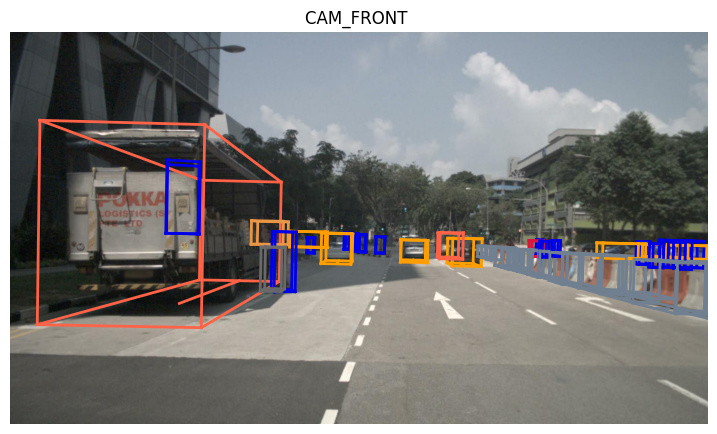

In [9]:
nusc.render_sample_data(cam_front_data['token'])

Using auxiliar functions to convert the 3D bounding boxes from nuScenes into 2D bounding boxes:

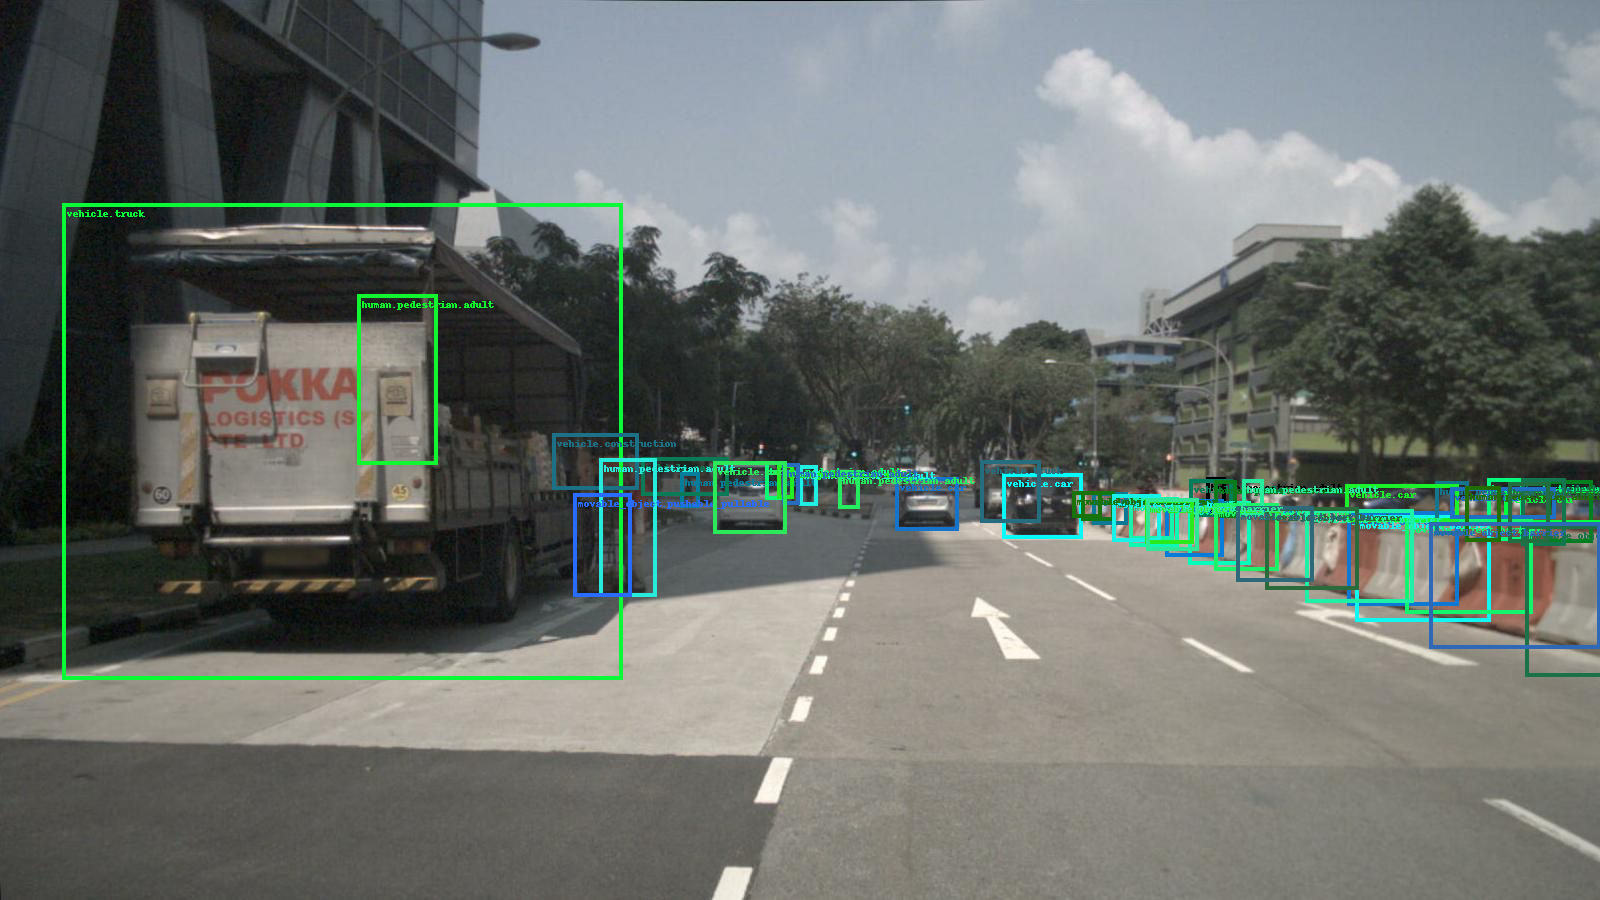

In [10]:
boxes, anns = get_2D_boxes_from_sample_data(nusc, cam_front_data['token'])

F.to_pil_image(draw_bounding_boxes(
    read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])),
    boxes=torch.tensor(boxes),
    labels=anns,
    width=4
))

Rendering the same image (without bounding boxes) with PyTorch utilities funtions:

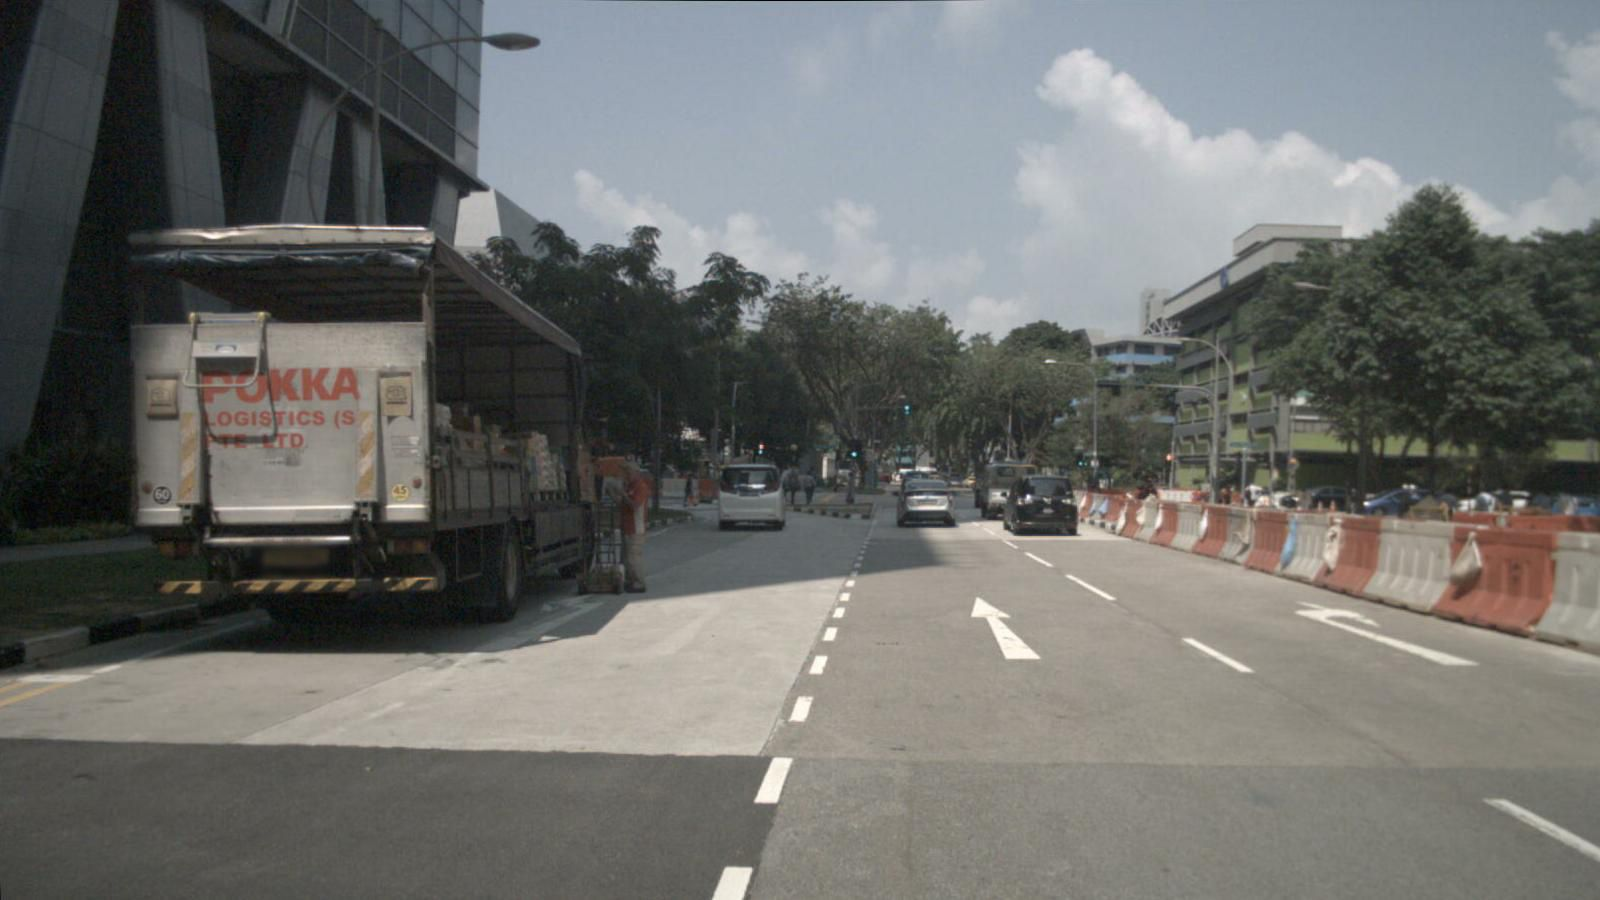

In [11]:
F.to_pil_image(read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])))

Making predictions on a single image only using the pretrained model:

In [12]:
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
print(model)

model.eval()

# list of predictions (per image):
out = model([IMAGE_PREPROCESSING_FUNCTION(read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])))])

Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /home/matheus/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

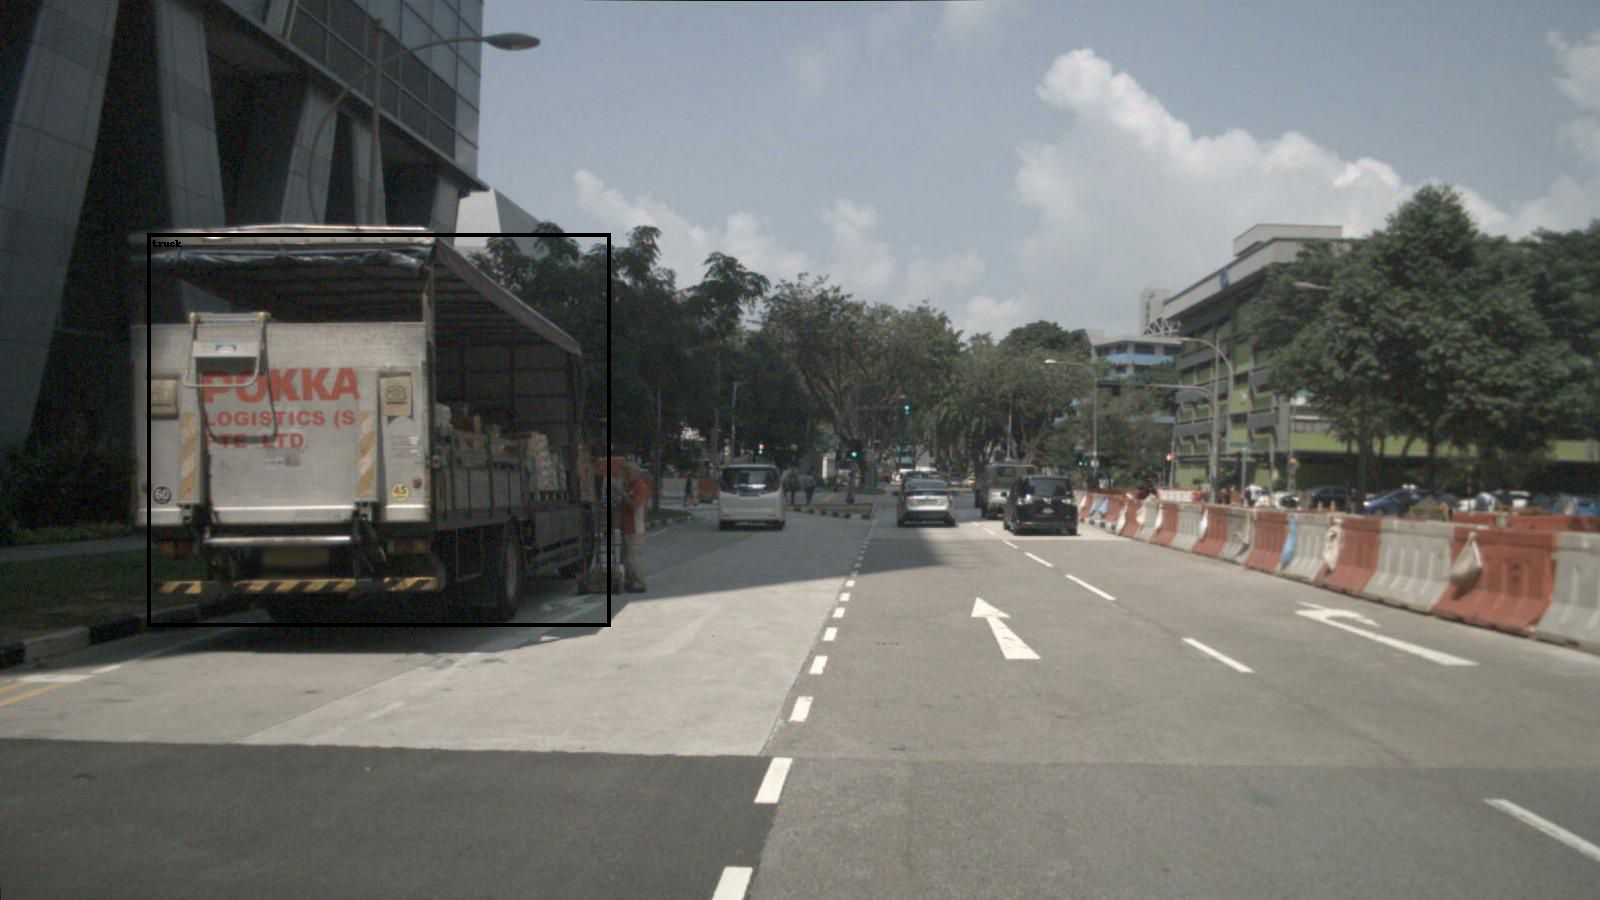

In [13]:
# filter the bounding boxes in order to select only the ones with a score higher than the DETECTION_THRESHOLD:
above_threshold_indices = out[0]['scores'] > DETECTION_THRESHOLD
filtered_boxes = out[0]['boxes'][above_threshold_indices]

# also filter the predicted labels, by selecting only the ones at the same indexes of the filtered bounding boxes:
filtered_labels = [SSD300_VGG16_Weights.DEFAULT.meta["categories"][label] for label in out[0]['labels'][above_threshold_indices]]

# render image with predicted and filtered boundig boxes and labels:
F.to_pil_image(draw_bounding_boxes(
    read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])),
    boxes=filtered_boxes,
    labels=filtered_labels,
    width=4,
))

### Training pretrained model on nuScenes dataset

Constants

In [20]:
BATCH_SIZE = 32

CLASSES = ['background', *[category['name'] for category in nusc.category]]
NUM_CLASSES = len(CLASSES)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

MODEL_NAME = 'ssd_model' # name to save the trained model with

NUM_EPOCHS = 10
NUM_WORKERS = 4

OUT_DIR = 'outputs'
os.makedirs(OUT_DIR, exist_ok=True)

RESIZE_PERCENT = 1
SAVE_MODEL_EPOCH = 5 # save model after these many epochs

TRAIN_NAME = 'mini_train'
VALIDATION_NAME = 'mini_val'

Dataset class

In [24]:
if __name__ == "__main__":
    cuda = torch.cuda.is_available()
    print('torch.cuda.is_available() is: {}\n'.format(cuda))

    clear_memory('/home/matheus/.cache/torch')

    # initialize the model and move to the computation device
    model = create_model(num_classes=NUM_CLASSES)
    model = model.to(DEVICE)

    # define the optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

    # train and validation loss lists to store loss values of all...
    # ... iterations till ena and plot graphs for all iterations
    train_loss_mean_list = []
    val_loss_mean_list = []

    train_dataset = NuScenesDataset(nusc, nusc.dataroot, TRAIN_NAME, CLASSES, ['1', '2', '3', '4'])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=lambda x: tuple(zip(*x)))

    valid_dataset = NuScenesDataset(nusc, nusc.dataroot, VALIDATION_NAME, CLASSES, ['1', '2', '3', '4'])
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=lambda x: tuple(zip(*x)))

    # start the training epochs
    for epoch in range(NUM_EPOCHS):
        print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")
        # start timer and carry out training and validation
        start = time.time()
        epoch_train_loss_list = train(train_loader, model, optimizer, DEVICE)
        epoch_val_loss_list = validate(valid_loader, model, DEVICE)

        train_loss_mean_list.append(sum(epoch_train_loss_list) / len(train_dataset))
        val_loss_mean_list.append(sum(epoch_val_loss_list) / len(valid_dataset))

        print(f"Epoch #{epoch} train loss average: {train_loss_mean_list[-1]:.3f}")   
        print(f"Epoch #{epoch} validation loss average: {val_loss_mean_list[-1]:.3f}")

        end = time.time()
        print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")
        
        if (epoch+1) % SAVE_MODEL_EPOCH == 0: # save model after every n epochs
            torch.save(model.state_dict(), f"{OUT_DIR}/model{epoch+1}.pth")
        
        if (epoch+1) == NUM_EPOCHS: # save loss plots and model once at the end
            save_val_train_mean_loss_joined_plot(train_loss_mean_list, val_loss_mean_list, 'SSD', OUT_DIR)
            torch.save(model.state_dict(), f"{OUT_DIR}/{MODEL_NAME}.pth")

    clear_memory('/home/matheus/.cache/torch')


torch.cuda.is_available() is: True



Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /home/matheus/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth


  0%|          | 0.00/136M [00:00<?, ?B/s]


EPOCH 1 of 10


Loss: 6.0711: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Epoch #0 train loss average: 11.749
Epoch #0 validation loss average: 6.484
Took 1.040 minutes for epoch 0

EPOCH 2 of 10


Loss: 4.9907: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch #1 train loss average: 6.252
Epoch #1 validation loss average: 5.397
Took 0.992 minutes for epoch 1

EPOCH 3 of 10


Loss: 4.8051: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Epoch #2 train loss average: 5.472
Epoch #2 validation loss average: 5.107
Took 0.998 minutes for epoch 2

EPOCH 4 of 10


Loss: 4.7891: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Epoch #3 train loss average: 5.042
Epoch #3 validation loss average: 4.996
Took 0.996 minutes for epoch 3

EPOCH 5 of 10


Loss: 4.7471: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch #4 train loss average: 4.732
Epoch #4 validation loss average: 4.957
Took 0.977 minutes for epoch 4

EPOCH 6 of 10


Loss: 4.8285: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


Epoch #5 train loss average: 4.501
Epoch #5 validation loss average: 4.980
Took 0.979 minutes for epoch 5

EPOCH 7 of 10


Loss: 4.8001: 100%|██████████| 16/16 [00:13<00:00,  1.20it/s]


Epoch #6 train loss average: 4.279
Epoch #6 validation loss average: 4.940
Took 0.984 minutes for epoch 6

EPOCH 8 of 10


Loss: 4.8522: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]


Epoch #7 train loss average: 4.087
Epoch #7 validation loss average: 4.929
Took 0.987 minutes for epoch 7

EPOCH 9 of 10


Loss: 4.8362: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


Epoch #8 train loss average: 3.862
Epoch #8 validation loss average: 4.866
Took 0.984 minutes for epoch 8

EPOCH 10 of 10


Loss: 4.8103: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]


Epoch #9 train loss average: 3.672
Epoch #9 validation loss average: 4.926
Took 0.986 minutes for epoch 9


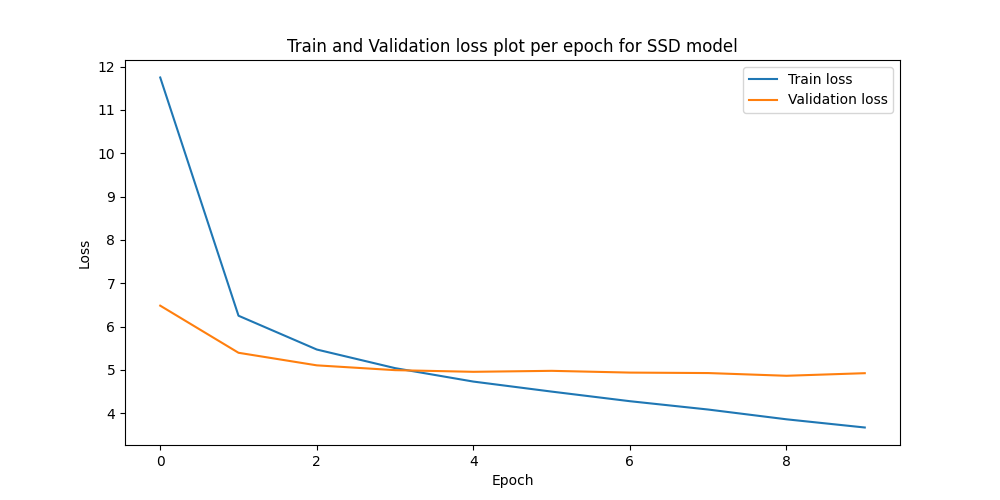

In [25]:
F.to_pil_image(read_image('outputs/loss_plot.png'))